In [1]:
import numpy as np
import tensorflow as tf

from tensorflow import keras 
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform

#from keras.utils import np_utils

2022-11-04 02:03:52.591789: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
def bottleneck_residual_block(X, f, filters, stage, block, reduce=False, s=2):
    """    
    Arguments:
    X -- input tensor of shape (m, height, width, channels)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    reduce -- boolean, True = identifies the reduction layer at the beginning of each learning stage
    s -- integer, strides
    
    Returns:
    X -- output of the identity block, tensor of shape (H, W, C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    if reduce:
        # if we are to reduce the spatial size, apply a 1x1 CONV layer to the shortcut path
        # to do that, we need both CONV layers to have similar strides 
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
        
        X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
        X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    else: 
        # First component of main path
        X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
        X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
        X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [3]:
def ResNet50(input_shape, classes):
    x_input = Input(input_shape)
    
    # Stage 1
    x = Conv2D(64, (7,7), (2,2), kernel_initializer=glorot_uniform(seed=0))(x_input)
    x = BatchNormalization(axis=3)(x)
    x = Activation("relu")(x)
    x = MaxPooling2D((3,3), (2,2))(x)
    
    # Stage 2
    x = bottleneck_residual_block(x, 3, [64, 64, 256],stage=2, block='a', reduce=True, s=1)
    x = bottleneck_residual_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = bottleneck_residual_block(x, 3, [64, 64, 256], stage=2, block='c')
    
    # Stage 3
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = bottleneck_residual_block(x, 3, [128, 128, 512], stage=3, block='d')
    
    # Stage 4
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = bottleneck_residual_block(x, 3, [256, 256, 1024], stage=4, block='f')
    
    # Stage 5
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='a', reduce=True, s=2)
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = bottleneck_residual_block(x, 3, [512, 512, 2048], stage=5, block='c')
    
    x = AveragePooling2D((1,1))(x)
    
    # Output layer
    x = Flatten()(x)
    x = Dense(classes, activation="softmax", name='fc' + str(classes))(x)
    
    model = Model(inputs = x_input, outputs = x, name="ResNet50")
    
    return model

In [4]:
model = ResNet50(input_shape = (224,224, 3), classes = 10)

2022-11-04 02:04:19.727566: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-04 02:04:19.748354: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2022-11-04 02:04:19.748407: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-04 02:04:19.748446: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mlops): /proc/driver/nvidia/version does not exist
2022-11-04 02:04:19.751171: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


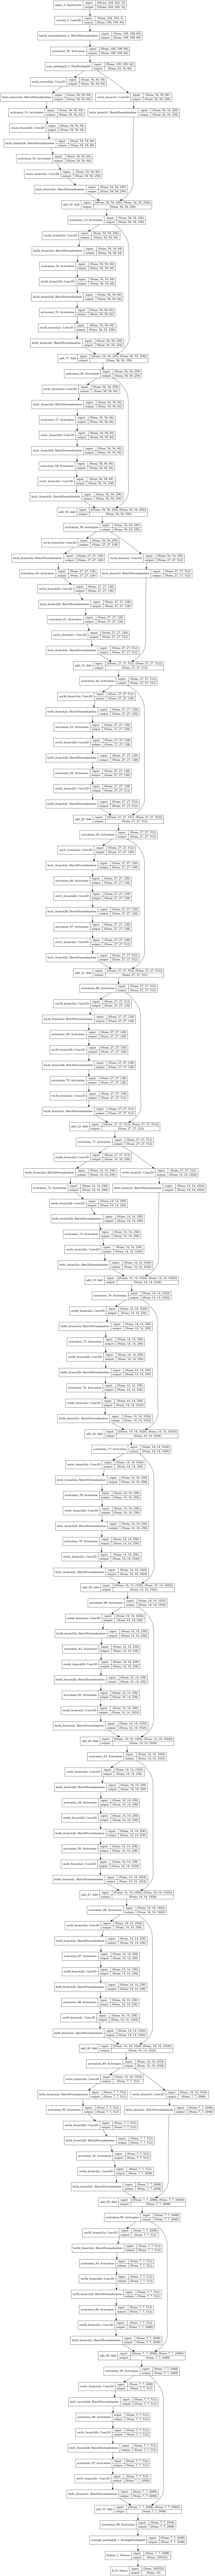

In [45]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

### Dataset

This tutorial uses a pre-trained image classification model from TensorFlow Hub, which is trained on ImageNet dataset.

Learn more about [ResNet V2 pretained model](https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5). 

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform $USER_FLAG -q
! pip3 install --upgrade google-cloud-pipeline-components $USER_FLAG -q
! pip3 install tensorflow-hub $USER_FLAG -q

^C
ERROR: Operation cancelled by user


In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

In [5]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
if PROJECT_ID == "" or PROJECT_ID is None or PROJECT_ID == "[your-project-id]":
    # Get your GCP project id from gcloud
    shell_output = ! gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID:", PROJECT_ID)

Project ID: project-daisuke-318402


In [6]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [7]:
REGION = "[your-region]"  # @param {type: "string"}

if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [8]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

In [9]:
BUCKET_NAME = "dk-model"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [10]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [51]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://dk-model/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [52]:
! gsutil ls -al $BUCKET_URI

In [28]:
!pip install tensorflow==2.4.0

In [27]:
import google.cloud.aiplatform as aip
import tensorflow as tf
import tensorflow_hub as hub

In [28]:
aip.init(project=PROJECT_ID, staging_bucket=BUCKET_URI)

*Executes in Colab*

In [ ]:
# tfhub_model = tf.keras.Sequential(
#     [hub.KerasLayer("https://tfhub.dev/google/imagenet/resnet_v2_101/classification/5")]
# )

# tfhub_model.build([None, 224, 224, 3])

# tfhub_model.summary()

In [29]:
MODEL_DIR = BUCKET_URI + "/model/resnet"
#model.save(MODEL_DIR)

In [30]:
CONCRETE_INPUT = "numpy_inputs"


def _preprocess(bytes_input):
    decoded = tf.io.decode_jpeg(bytes_input, channels=3)
    decoded = tf.image.convert_image_dtype(decoded, tf.float32)
    resized = tf.image.resize(decoded, size=(224, 224))
    return resized


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def preprocess_fn(bytes_inputs):
    decoded_images = tf.map_fn(
        _preprocess, bytes_inputs, dtype=tf.float32, back_prop=False
    )
    return {
        CONCRETE_INPUT: decoded_images
    }  # User needs to make sure the key matches model's input


@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def serving_fn(bytes_inputs):
    images = preprocess_fn(bytes_inputs)
    prob = m_call(**images)
    return prob


m_call = tf.function(model.call).get_concrete_function(
    [tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32, name=CONCRETE_INPUT)]
)

tf.saved_model.save(model, MODEL_DIR, signatures={"serving_default": serving_fn})

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead


2022-11-04 02:17:26.641167: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: gs://dk-model/model/resnet/assets


In [31]:
loaded = tf.saved_model.load(MODEL_DIR)

serving_input = list(
    loaded.signatures["serving_default"].structured_input_signature[1].keys()
)[0]
print("Serving function input:", serving_input)

Serving function input: bytes_inputs


In [22]:
import os

PRIVATE_REPO = "model-repository"

! gcloud artifacts repositories create {PRIVATE_REPO} --repository-format=docker --location={REGION} --description="Docker repository"

! gcloud artifacts repositories list

if os.getenv("IS_TESTING_DEPLOY_GPU"):
    DEPLOY_GPU, DEPLOY_NGPU = (
        aip.gapic.AcceleratorType.NVIDIA_TESLA_K80,
        int(os.getenv("IS_TESTING_DEPLOY_GPU")),
    )
else:
    DEPLOY_GPU, DEPLOY_NGPU = (None, None)

# Executes in Vertex AI Workbench
if os.getenv("IS_TESTING_DEPLOY_MACHINE"):
    MACHINE_TYPE = os.getenv("IS_TESTING_DEPLOY_MACHINE")
else:
    MACHINE_TYPE = "n1-standard"

VCPU = "4"
DEPLOY_COMPUTE = MACHINE_TYPE + "-" + VCPU
print("Train machine type", DEPLOY_COMPUTE)

if DEPLOY_GPU:
    DEPLOY_IMAGE = (
        f"{REGION}-docker.pkg.dev/"
        + PROJECT_ID
        + f"/{PRIVATE_REPO}"
        + "/tf_serving:gpu"
    )
    TF_IMAGE = "tensorflow/serving:2.5.4-gpu"
else:
    DEPLOY_IMAGE = (
        f"{REGION}-docker.pkg.dev/"
        + PROJECT_ID
        + f"/{PRIVATE_REPO}"
        + "/tf_serving:cpu"
    )
    TF_IMAGE = "tensorflow/serving:2.5.4"


if DEPLOY_GPU:
    ! sudo docker pull tensorflow/serving:2.5.4-gpu
else:
    ! sudo docker pull tensorflow/serving:2.5.4

! docker tag $TF_IMAGE $DEPLOY_IMAGE
! docker push $DEPLOY_IMAGE


print("Deployment:", DEPLOY_IMAGE, DEPLOY_GPU, DEPLOY_NGPU)

ERROR: (gcloud.artifacts.repositories.create) ALREADY_EXISTS: the repository already exists
Listing items under project project-daisuke-318402, across all locations.

                                                                      ARTIFACT_REGISTRY
REPOSITORY        FORMAT  MODE                 DESCRIPTION        LOCATION     LABELS  ENCRYPTION          CREATE_TIME          UPDATE_TIME          SIZE (MB)
model-repository  DOCKER  STANDARD_REPOSITORY  Docker repository  us-central1          Google-managed key  2022-11-04T02:11:05  2022-11-04T02:11:05  0
my-docker-repo    DOCKER  STANDARD_REPOSITORY  Docker repository  us-central1          Google-managed key  2022-06-03T22:03:52  2022-11-04T00:48:20  2971.573
template          DOCKER  STANDARD_REPOSITORY                     us-central1          Google-managed key  2022-10-30T03:10:25  2022-10-30T03:22:46  1172.612
Train machine type n1-standard-4
2.5.4: Pulling from tensorflow/serving
Digest: sha256:4b19e8aa6cf87b8585e430bdc6a07cf0

In [34]:
MODEL_NAME = "Resnet" + TIMESTAMP

model = aip.Model.upload(
    display_name="Resnet" + TIMESTAMP,
    artifact_uri=MODEL_DIR,
    serving_container_image_uri=DEPLOY_IMAGE,
    serving_container_health_route="/v1/models/" + MODEL_NAME,
    serving_container_predict_route="/v1/models/" + MODEL_NAME + ":predict",
    serving_container_command=["/usr/bin/tensorflow_model_server"],
    serving_container_args=[
        "--model_name=" + MODEL_NAME,
        "--model_base_path=" + "$(AIP_STORAGE_URI)",
        "--rest_api_port=8080",
        "--port=8500",
        "--file_system_poll_wait_seconds=31540000",
    ],
    serving_container_ports=[8080],
)

print(model)

Creating Model
Create Model backing LRO: projects/437739257142/locations/us-central1/models/6972623356285681664/operations/5334172154101497856
Model created. Resource name: projects/437739257142/locations/us-central1/models/6972623356285681664@1
To use this Model in another session:
model = aiplatform.Model('projects/437739257142/locations/us-central1/models/6972623356285681664@1')
resource name: projects/437739257142/locations/us-central1/models/6972623356285681664


In [35]:
endpoint = aip.Endpoint.create(
    display_name="Resnet" + TIMESTAMP,
    project=PROJECT_ID,
    location=REGION,
    labels={"model": "resnet"},
)

print(endpoint)

Creating Endpoint
Create Endpoint backing LRO: projects/437739257142/locations/us-central1/endpoints/5174851476127744000/operations/2799771463798751232
Endpoint created. Resource name: projects/437739257142/locations/us-central1/endpoints/5174851476127744000
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/437739257142/locations/us-central1/endpoints/5174851476127744000')
resource name: projects/437739257142/locations/us-central1/endpoints/5174851476127744000


In [ ]:
response = endpoint.deploy(
    model=model,
    deployed_model_display_name="example_" + TIMESTAMP,
    machine_type=DEPLOY_COMPUTE,
)

print(endpoint)

Deploying Model projects/437739257142/locations/us-central1/models/6972623356285681664 to Endpoint : projects/437739257142/locations/us-central1/endpoints/5174851476127744000
Deploy Endpoint model backing LRO: projects/437739257142/locations/us-central1/endpoints/5174851476127744000/operations/3078994640695721984


In [ ]:
! gsutil cp gs://cloud-ml-data/img/flower_photos/daisy/100080576_f52e8ee070_n.jpg test.jpg

In [ ]:
import base64

with open("test.jpg", "rb") as f:
    data = f.read()
b64str = base64.b64encode(data).decode("utf-8")

In [ ]:
# The format of each instance should conform to the deployed model's prediction input schema.
instances = [{serving_input: {"b64": b64str}}]

prediction = endpoint.predict(instances=instances)

print(prediction)

### Make the batch input file

Next, make a batch input file, which you store in your local Cloud Storage bucket. For custom models, you format the batch input file in JSONL format. Each JSON object entry in the JSONL file is specified in the same format as you specified for the online prediction request.

In otherwords, both online and batch prediction use the same predict request format. The difference is that with online prediction, you pass the request as an in-memory dictionary object using the SDK method `predict()`. For batch prediction, you write each prediction request (dictionary entry) as a JSON object, one per line.

The dictionary contains the key/value pairs:

- `input_name`: the name of the input layer of the underlying model.
- `'b64'`: A key that indicates the content is base64 encoded.
- `content`: The compressed JPG image bytes as a base64 encoded string.

Each instance in the prediction request is a dictionary entry of the form:

                        {serving_input: {'b64': content}}

To pass the image data to the prediction service you encode the bytes into base64 -- which makes the content safe from modification when transmitting binary data over the network.

In [ ]:
# For demonstration purposes, you write the same image (instance[0]) request twice to the JSONL file.
# You will receive back two predictions, one for each instance.

import json

with open("test.jsonl", "w") as f:
    json.dump(instances[0], f)
    f.write("\n")
    json.dump(instances[0], f)

! gsutil cp test.jsonl {BUCKET_URI}/test.jsonl

In [ ]:
MIN_NODES = 1
MAX_NODES = 1

batch_predict_job = model.batch_predict(
    job_display_name="example_" + TIMESTAMP,
    instances_format="jsonl",
    predictions_format="jsonl",
    model_parameters=None,
    gcs_source=f"{BUCKET_URI}/test.jsonl",
    gcs_destination_prefix=f"{BUCKET_URI}/results",
    machine_type=DEPLOY_COMPUTE,
    accelerator_type=DEPLOY_GPU,
    accelerator_count=DEPLOY_NGPU,
    starting_replica_count=MIN_NODES,
    max_replica_count=MAX_NODES,
    sync=False,
)

### Wait for completion of batch prediction job

Next, wait for the batch job to complete. Alternatively, one can set the parameter `sync` to `True` in the `batch_predict()` method to block until the batch prediction job is completed.

In [ ]:
batch_predict_job.wait()

### Get the predictions

Next, get the results from the completed batch prediction job.

The results are written to the Cloud Storage output bucket you specified in the batch prediction request. You call the method iter_outputs() to get a list of each Cloud Storage file generated with the results. Each file contains one or more prediction requests in a JSON format:

- `instance`: The prediction request.
- `prediction`: The prediction response.

In [ ]:
import json

bp_iter_outputs = batch_predict_job.iter_outputs()

prediction_results = list()
for blob in bp_iter_outputs:
    if blob.name.split("/")[-1].startswith("prediction"):
        prediction_results.append(blob.name)

tags = list()
for prediction_result in prediction_results:
    gfile_name = f"gs://{bp_iter_outputs.bucket.name}/{prediction_result}"
    with tf.io.gfile.GFile(name=gfile_name, mode="r") as gfile:
        for line in gfile.readlines():
            line = json.loads(line)
            print(line)
            break

## Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [38]:
delete_bucket = True
delete_model = True
delete_endpoint = True
delete_batch_job = True

if delete_endpoint:
    try:
        endpoint.undeploy_all()
        endpoint.delete()
    except Exception as e:
        print(e)

if delete_model:
    try:
        model.delete()
    except Exception as e:
        print(e)

if delete_bucket:
    try:
        batch_predict_job.delete()
    except Exception as e:
        print(e)

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -rf {BUCKET_URI}

Undeploying Endpoint model: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


Undeploy Endpoint model backing LRO: projects/437739257142/locations/us-central1/endpoints/3554681510181208064/operations/7881942905798000640


INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/437739257142/locations/us-central1/endpoints/3554681510181208064/operations/7881942905798000640


Endpoint model undeployed. Resource name: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


Deleting Endpoint : projects/437739257142/locations/us-central1/endpoints/3554681510181208064


INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/437739257142/locations/us-central1/endpoints/3554681510181208064


Delete Endpoint  backing LRO: projects/437739257142/locations/us-central1/operations/3660381205091581952


INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/437739257142/locations/us-central1/operations/3660381205091581952


Endpoint deleted. . Resource name: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/437739257142/locations/us-central1/endpoints/3554681510181208064


Deleting Model : projects/437739257142/locations/us-central1/models/4216420384334938112


INFO:google.cloud.aiplatform.base:Deleting Model : projects/437739257142/locations/us-central1/models/4216420384334938112


Delete Model  backing LRO: projects/437739257142/locations/us-central1/operations/1099521866978033664


INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/437739257142/locations/us-central1/operations/1099521866978033664


Model deleted. . Resource name: projects/437739257142/locations/us-central1/models/4216420384334938112


INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/437739257142/locations/us-central1/models/4216420384334938112


Deleting BatchPredictionJob : projects/437739257142/locations/us-central1/batchPredictionJobs/4161547882161242112


INFO:google.cloud.aiplatform.base:Deleting BatchPredictionJob : projects/437739257142/locations/us-central1/batchPredictionJobs/4161547882161242112


Delete BatchPredictionJob  backing LRO: projects/437739257142/locations/us-central1/operations/6063051606293741568


INFO:google.cloud.aiplatform.base:Delete BatchPredictionJob  backing LRO: projects/437739257142/locations/us-central1/operations/6063051606293741568


BatchPredictionJob deleted. . Resource name: projects/437739257142/locations/us-central1/batchPredictionJobs/4161547882161242112


INFO:google.cloud.aiplatform.base:BatchPredictionJob deleted. . Resource name: projects/437739257142/locations/us-central1/batchPredictionJobs/4161547882161242112


Removing gs://project-daisuke-318402aip-20221103070806/test.jsonl#1667460666194342...
Removing gs://project-daisuke-318402aip-20221103070806/model/#1667459360357597...
Removing gs://project-daisuke-318402aip-20221103070806/model/1/#1667459360520130...
Removing gs://project-daisuke-318402aip-20221103070806/model/1/assets/#1667459365438367...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://project-daisuke-318402aip-20221103070806/model/1/saved_model.pb#1667459381950435...
Removing gs://project-daisuke-318402aip-20221103070806/model/1/variables/#1667459360662550...
Removing gs://project-daisuke-318402aip-20221103070806/model/1/variables/variables.data-00000-of-00001#1667459380903967...
Removing 

# https://www.tensorflow.org/guide/saved_model#specifying_signatures_during_export